# A1 - Building a Model for the Synthesis of Tabular Healthcare Data
- **Nome:** Kristhian André Oliveira Aguilar
- **Matrícula:** 298976

O objetivo deste trabalho é desenvolver um modelo capaz de gerar dados tabulares de saúde de forma **realista**, com foco em exames de hemograma. Consideramos realista a combinação de dois níveis de conhecimento [1]. O primeiro, chamado **extrínseco**, refere-se à preservação da estrutura dos dados originais: mesmas colunas, tipos e domínios válidos de valores. O segundo, denominado **intrínseco**, envolve a captura de padrões mais complexos, como distribuições conjuntas e correlações entre variáveis.

No caso do hemograma, isso significa que os dados sintetizados devem respeitar limites fisiológicos (por exemplo, não produzir idades negativas ou valores irreais de plaquetas como 0 × 10³/μL) e também refletir relações conhecidas, como a contagem de plaquetas geralmente maior em crianças do que em adultos. A preservação dessas relações será utilizada como critério de avaliação da qualidade dos dados gerados.

## Metodologia

### Imports e aquisição dos dados

As bibliotecas necessárias para este trabalho são:
- `pandas` para manipulação de dados tabulares,
- `numpy` para operações numéricas,
- `matplotlib` e `seaborn` para visualização de dados
- `pymc` para modelagem probabilística.
- `ipywidgets` para interatividade.
- `scipy` para estatísticas avançadas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import pymc as pm

Abaixo está o código para aquisição dos dados. Estes consistem em três arquivos CSV, todos com sem cabeçalho. Após análise dos dados, foi determinado a representação de cada coluna, da esquerda para a direita, como:

- `timestamp`: Data e hora da coleta do hemograma. Tipo `datetime64[ns]`
- `age`: Idade do paciente em anos. Tipo `int`
- `id`: Identificador único do paciente. Tipo `str`
- `sex`: Sexo do paciente (M ou F). Tipo `category`
- `analyte`: Nome do exame realizado. Tipo `category`
- `value`: Valor do exame. Com exceção dos campos de observação que foram removidos, os valores são do tipo `float64`. Assumiu-se que cada os valores observados estão em unidades padrão, como `10³/μL` para plaquetas e leucócitos, e `g/dL` para hemoglobina.


No código abaixo, os três arquivos CSV são lidos e concatenados em um único DataFrame. As colunas são renomeadas para facilitar a manipulação e análise dos dados. Além disso, as colunas de observação foram removidas, pois estavam vazias.

In [2]:
main_category_map = {
    "PLAQUETAS SANGUE": "platelets",
    "NEUTRÓFILOS ABSOLUTO": "neut_abs",
    "NEUTRÓFILOS %": "neut_pct",
    "NEUTRÓFILOS SEGMENTADOS %": "neut_segmented_pct",
    "LINFÓCITOS ABSOLUTO": "lym_abs",
    "LINFÓCITOS %": "lym_pct",
    "LINFOCITOS ATIPICOS TOTAL %": "lym_atypical_pct",
    "LEUCÓCITOS TOTAIS": "wbc_total",
    "EOSINÓFILOS ABSOLUTO": "eos_abs",
    "LUC ABSOLUTO": "luc_abs",
    "LUC %": "luc_pct",
    "PLASMÓCITOS ABSOLUTO": "pc_abs",
    "PLASMÓCITOS%": "pc_pct",
    "MCHC": "mchc",
    "OBSERVAÇÃO WBC": "obsservation_wbc",
    "OBSERVAÇÃO RBC": "observation_rbc",
    "OBSERVAÇÃO PLT": "observation_plt",
}

dataframes = []
for file in ['data1.csv', 'data2.csv', 'data3.csv']:
    df = pd.read_csv(file, header=None, 
                     names=['timestamp', 'age', 'id', 'sex', 'analyte', 'value'],
                     dtype={
                         'timestamp': 'str',
                         'age': 'int',
                         'id': 'str',
                         'sex': 'category',
                        'analyte': 'str',
                            'value': 'str'
                     })
    dataframes.append(df)
    
df = pd.concat(dataframes, ignore_index=True)

# switch the id column position with the age column
df = df[['timestamp', 'id', 'age', 'sex', 'analyte', 'value']]

# for the str camps to be strictly strings, we convert the 'value' column to string type
df['value'] = df['value'].astype(str)

df['value'] = df['value'].str.replace(',', '.', regex=False)

# remove rows that contain 'nan', or only spaces in the 'value' column
df = df[~df['value'].str.strip().isin(['nan', ''])]

# # convert 'value' column to float, coercing errors to NaN
df['value'] = pd.to_numeric(df['value'])

# remove rows where 'value' is NaN
df = df.dropna(subset=['value'])

df['analyte'] = df['analyte'].map(main_category_map).astype('category')

# convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# sort by timestamp and id
df = df.sort_values(by=['timestamp', 'id']).reset_index(drop=True)

### Escolha de variável para síntese

A fim de simplificar o processo de síntese, foi escolhida a variável `platelets` (plaquetas) como alvo. Ela foi escolhida por ser a variável mais frequente entre os exames realizados, conforme mostrado no gráfico abaixo. Além disso, é a variável mais independente já que não depende diretamente de nenhum outro tipo de exame, o que facilita a modelagem.

#### Figura 1

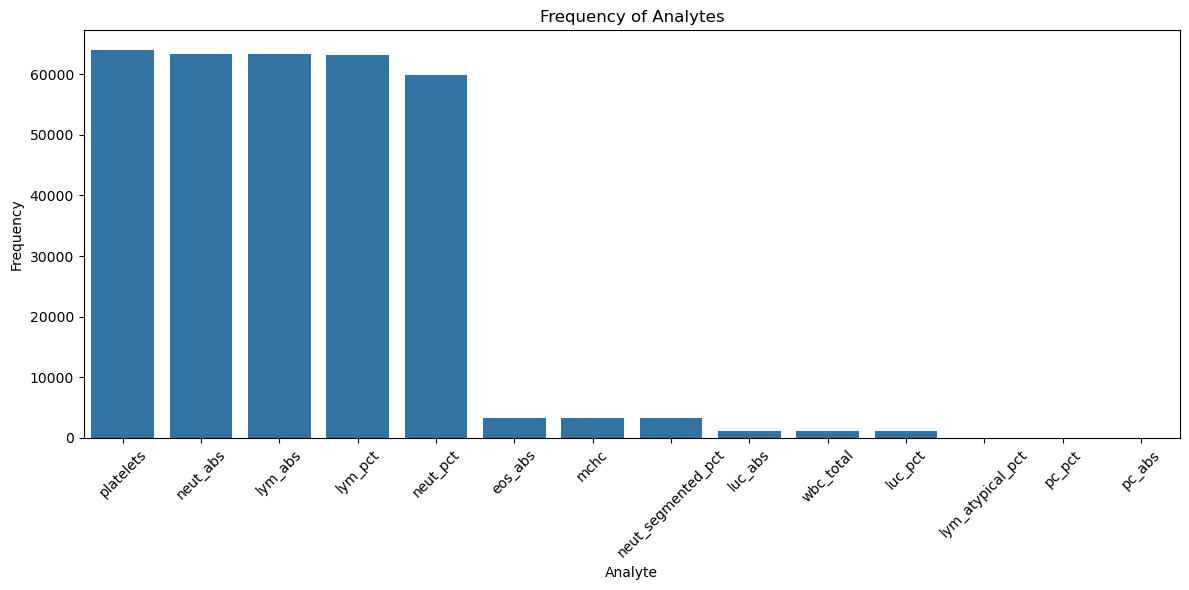

In [3]:
# plot frequency of each analyte
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='analyte', order=df['analyte'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Frequency of Analytes')
plt.xlabel('Analyte')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [4]:
df = df[df['analyte'] == 'platelets']

### Limpeza e preprocessamento dos dados

#### Remoção de amostras duplicadas

Uma exploração inicial dos dados revelou uma quantidade significativa de valores duplicados. 1013 amostras com o mesmo `id` e `timestamp` foram encontradas e removidas. Além disso, as figura 2 mostram uma grande quantidade de exames com mesmo `id` feitos dentro de um intervalo de 1 hora. Isto sugere que muitos pacientes realizaram múltiplos exames em um curto período de tempo, o que é possível no caso de pacientes internados ou com condições de saúde que exigem monitoramento frequente. No entanto, a figura 3 mostra que há registros de pacientes com 3 ou mais exames feitos em um intervalo de 1 hora, o que é considerado anômalo. Para evitar a geração de dados sintéticos com essas características, esses registros foram removidos.

In [5]:
# remove duplicates
previous_length = len(df)
df = df.drop_duplicates(subset=['id', 'timestamp'])
if len(df) < previous_length:
    print(f"Removed {previous_length - len(df)} duplicate rows.")

Removed 543 duplicate rows.


##### Figura 2

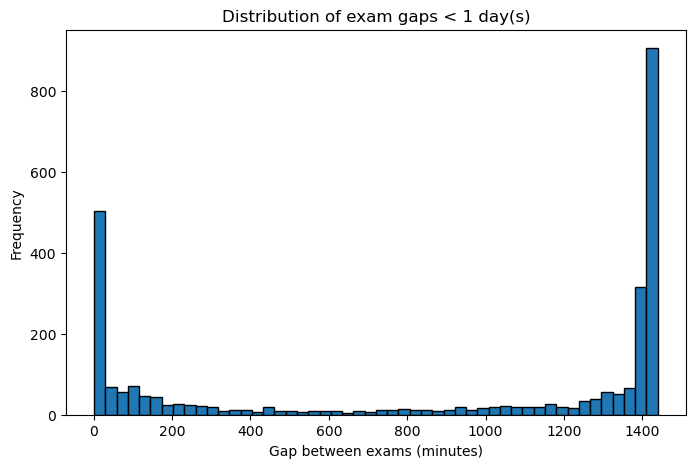

In [6]:
def assign_exam_groups(
    df: pd.DataFrame, time_threshold: pd.Timedelta | None = None
) -> pd.DataFrame:
    """
    Assigns exam group IDs for each patient.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'id' and 'timestamp' columns.
    time_threshold : pd.Timedelta or None
        If None, groups by exact timestamp.
        If set, groups consecutive rows for the same patient
        when the gap is <= time_threshold.
    
    Returns
    -------
    pd.DataFrame
        Original DataFrame with 'exam_group' and 'global_exam_id' columns.
    """
    df = df.sort_values(["id", "timestamp"]).copy()

    if time_threshold is None:
        # Exact timestamp grouping
        df["exam_group"] = df.groupby(["id", "timestamp"], sort=False).ngroup()
    else:
        # Time threshold grouping
        df["new_exam"] = (
            df.groupby("id")["timestamp"]
            .diff()
            .gt(time_threshold)
            .fillna(True)
        )
        df["exam_group"] = df.groupby("id")["new_exam"].cumsum().astype(int)
        df = df.drop(columns="new_exam")

    # Create a global exam ID string
    df["global_exam_id"] = (
        df["id"].astype(str) + "_" + df["exam_group"].astype(str)
    )

    return df

def exam_time_gaps(df_grouped: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates time differences between consecutive exams for each patient
    from a DataFrame that already has 'exam_group'.
    """
    # Get the first timestamp of each exam
    exam_times = (
        df_grouped.groupby(["id", "exam_group"])["timestamp"]
        .min()
        .reset_index()
        .sort_values(["id", "timestamp"])
    )

    # Calculate time difference between consecutive exams
    exam_times["time_diff"] = exam_times.groupby("id")["timestamp"].diff()

    return exam_times


def plot_small_gaps(exam_times: pd.DataFrame, max_days: int = 1):
    """
    Plots histogram of time differences up to max_days.
    """
    small_gaps = exam_times["time_diff"].dropna()
    small_gaps = small_gaps[small_gaps < pd.Timedelta(days=max_days)]
    small_gaps_minutes = small_gaps.dt.total_seconds() / 60

    plt.figure(figsize=(8, 5))
    plt.hist(small_gaps_minutes, bins=50, edgecolor="black")
    plt.xlabel("Gap between exams (minutes)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of exam gaps < {max_days} day(s)")
    plt.show()

# 1. Group exams (exact timestamp)
df_grouped = assign_exam_groups(df, time_threshold=None)

# 2. Calculate time gaps
gaps_df = exam_time_gaps(df_grouped)

# 3. Inspect stats
# 4. Plot small gaps
plot_small_gaps(gaps_df, max_days=1)

##### Figura 3

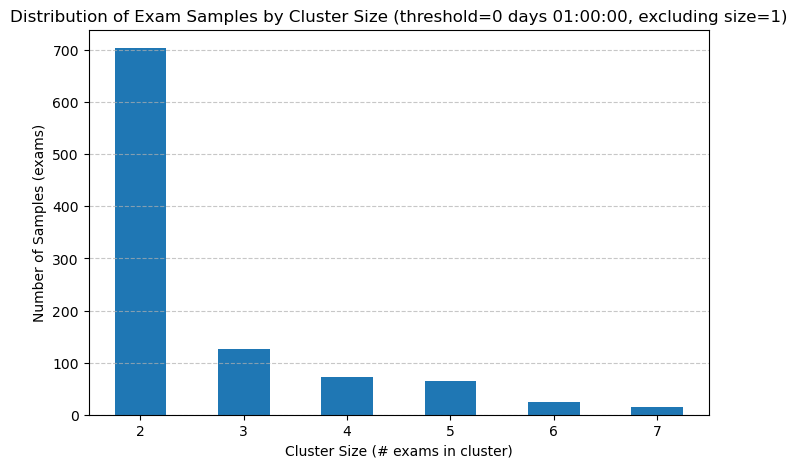

In [7]:
def plot_cluster_sample_distribution(
    df: pd.DataFrame, time_threshold: pd.Timedelta = pd.Timedelta(hours=1)
):
    """
    Plots the distribution of exam samples by cluster size for a given time threshold,
    excluding clusters of size 1.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'id' and 'timestamp' columns.
    time_threshold : pd.Timedelta
        Maximum time gap allowed within a cluster.
    """
    df = df.sort_values(["id", "timestamp"]).copy()

    # Compute time difference from previous exam
    df["time_diff"] = df.groupby("id")["timestamp"].diff()

    # Define clusters: start a new cluster when gap > threshold or first exam
    df["new_cluster"] = df["time_diff"].isna() | (df["time_diff"] > time_threshold)
    df["cluster_id"] = df.groupby("id")["new_cluster"].cumsum()

    # Count cluster sizes
    cluster_sizes = (
        df.groupby(["id", "cluster_id"])["timestamp"].count().reset_index(name="size")
    )

    # Exclude clusters of size 1
    cluster_sizes = cluster_sizes[cluster_sizes["size"] > 1]

    # Compute number of samples per cluster size
    # (cluster size * number of clusters of that size)
    sample_counts = (
        cluster_sizes["size"].value_counts().sort_index()
        * cluster_sizes["size"].value_counts().sort_index().index
    )

    # Plot
    plt.figure(figsize=(8, 5))
    sample_counts.plot(kind="bar")
    plt.title(
        f"Distribution of Exam Samples by Cluster Size "
        f"(threshold={time_threshold}, excluding size=1)"
    )
    plt.xlabel("Cluster Size (# exams in cluster)")
    plt.ylabel("Number of Samples (exams)")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    return sample_counts


# Example usage:
sample_counts = plot_cluster_sample_distribution(df, pd.Timedelta(hours=1))

In [8]:
def drop_close_exams(
    df: pd.DataFrame,
    time_threshold: pd.Timedelta = pd.Timedelta(hours=1),
    min_cluster_size: int = 3,
) -> pd.DataFrame:
    """
    Removes rows where exams for the same patient happen within 'time_threshold',
    but only if there are at least `min_cluster_size` exams in that close cluster.
    Keeps only the earliest exam in each qualifying cluster.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'id' and 'timestamp' columns.
    time_threshold : pd.Timedelta
        Minimum allowed time between exams from the same patient.
    min_cluster_size : int, default=3
        Minimum number of exams in a cluster before dropping applies.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with close exams removed.
    """
    df = df.sort_values(["id", "timestamp"]).copy()

    # Compute time difference from previous exam
    df["time_diff"] = df.groupby("id")["timestamp"].diff()

    # Define clusters: start a new cluster when gap > threshold or first exam
    df["new_cluster"] = df["time_diff"].isna() | (df["time_diff"] > time_threshold)
    df["cluster_id"] = df.groupby("id")["new_cluster"].cumsum()

    # Count cluster sizes
    df["cluster_size"] = df.groupby(["id", "cluster_id"])["timestamp"].transform("count")

    # Keep rule:
    # - If cluster size < min_cluster_size → keep all
    # - If cluster size >= min_cluster_size → keep only the first exam in that cluster
    df["keep"] = (df["cluster_size"] < min_cluster_size) | (
        (df["cluster_size"] >= min_cluster_size)
        & (df.groupby(["id", "cluster_id"]).cumcount() == 0)
    )

    result = df[df["keep"]].drop(
        columns=["time_diff", "new_cluster", "cluster_id", "cluster_size", "keep"]
    )

    dropped_count = len(df) - len(result)
    print(
        f"Dropped {dropped_count} exams from clusters with ≥ {min_cluster_size} exams "
        f"within {time_threshold}."
    )

    return result

df = drop_close_exams(df, pd.Timedelta(hours=1), min_cluster_size=3)

Dropped 222 exams from clusters with ≥ 3 exams within 0 days 01:00:00.


#### Remoção de outliers

A remoção de outliers é uma etapa importante, em especial para dados de saúde, onde valores fora do esperado podem indicar condições clínicas raras. Incluir estes valores distorce a distruibuição, o que pode ser apropriado se o objetivo for utilizar os dados no contexto de detecção de anomalias, mas não é desejável quando o objetivo é gerar dados sintéticos que representem a população geral. 

Para os propósitos deste trabalho, optou-se por não remover os outliers por padrão, permitindo que o usuário decida se deseja ou não removê-los ao utilizar a função principal.

In [9]:
print(f"Number of exams with value > 1200 x 10³/μL: {len(df[df['value'] > 1200])} ({len(df[df['value'] > 1200]) / len(df) * 100:.2f}%)")
print(f"Number of exams with value < 50 x 10³/μL: {len(df[df['value'] < 50])} ({len(df[df['value'] < 50]) / len(df) * 100:.2f}%)")


def remove_outliers_log_iqr(df, column='value', multiplier=1.5):
    """
    Remove outliers using log transformation and IQR method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    column : str
        Column name to filter outliers from
    multiplier : float
        IQR multiplier for outlier detection (default 1.5)
    
    Returns:
    --------
    pd.DataFrame
        Filtered dataframe without outliers
    """
    df_filtered = df.copy()
    
    # Apply log transformation (add small constant to avoid log(0))
    log_values = np.log(df_filtered[column] + 1e-6)
    
    # Calculate IQR on log-transformed values
    Q1 = log_values.quantile(0.25)
    Q3 = log_values.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds in log space
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # Filter outliers
    mask = (log_values >= lower_bound) & (log_values <= upper_bound)
    df_filtered = df_filtered[mask]
    
    removed_count = len(df) - len(df_filtered)
    print(f"Removed {removed_count} outliers ({removed_count/len(df)*100:.2f}%)")
    print(f"Remaining samples: {len(df_filtered)}")
    
    return df_filtered

df = remove_outliers_log_iqr(df, column='value', multiplier=1)

Number of exams with value > 1200 x 10³/μL: 22 (0.03%)
Number of exams with value < 50 x 10³/μL: 2490 (3.93%)
Removed 7527 outliers (11.89%)
Remaining samples: 55769


#### Categorizazação de idade

Para simplificar a análise, o campo de idade foi categorizado em faixas etárias relevantes para a contagem de plaquetas [2]:
- `0-14`: Crianças
- `15-64`: Adultos
- `65+`: Idosos

O modelo de síntese utilizará essas categorias em vez da idade exata, e converterá de volta para a idade numérica ao gerar os dados sintéticos.

In [10]:
# categorize age into bins

from numpy import add


def add_age_group(df: pd.DataFrame):
    """
    Categorizes age into bins and adds an 'age_group' column to the DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing an 'age' column.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with an additional 'age_group' column.
    """
    age_bins = [0, 14, 64, np.inf]
    age_labels = ['child', 'adult', 'elderly']
    df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)

add_age_group(df)
print(df['age_group'].value_counts())

age_group
adult      36699
elderly    16121
child       2949
Name: count, dtype: int64


### Critérios de avaliação

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55769 entries, 51096 to 327076
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  55769 non-null  datetime64[ns]
 1   id         55769 non-null  object        
 2   age        55769 non-null  int64         
 3   sex        55769 non-null  category      
 4   analyte    55769 non-null  category      
 5   value      55769 non-null  float64       
 6   age_group  55769 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


Como dito anteriormente, para obter dados sintéticos realistas é necessário capturar as propriedades intrínsecas e extrínsecas dos dados originais. 

Para avaliar as propriedades intrínsecas, serão utilizadas uma série de validações para garantir que os dados sintéticos respeitem os limites possíveis para cada variável. Os testes são: a idade deve ser um número positivo menor que 140, o sexo deve ser M ou F e os valores de plaquetas devem estar dentro de um intervalo fisiológico (0-5000 × 10³/μL). Este intervalo varia caso o usuário opte por remover os outliers.

Já para as propriedades extrínsecas, serão utilizadas as seguintes validações:
- **Distribuições marginais**: As distribuições univariadas de cada variável devem ser preservadas. A distribuição de idades e sexo devem ser semelhantes à dos dados originais, e a distribuição de plaquetas deve seguir uma distribuição normal com média e desvio padrão semelhantes aos dados originais.
- **Distribuições condicionais**: As distribuições condicionais entre variáveis devem ser preservadas. A distribuição de plaquetas condicionada à idade deve ser semelhante à dos dados originais, onde crianças tendem a ter mais plaquetas do que adultos, e estes mais do que idosos [2]. A distribuição de plaquetas condicionada ao sexo também deve ser semelhante, com mulheres tendendo a ter mais plaquetas do que homens [2].

Ambas propriedades serão avaliadas utilizando o teste de Kolmogorov-Smirnov (KS), que mede a distância máxima entre duas distribuições empíricas. Um valor de KS próximo de 0 indica que as distribuições são semelhantes, enquanto um valor próximo de 1 indica que são diferentes. Estas propriedades dos dados podem ser vistas na tabela 1 e figuras 4, 5 e 6.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def preprocess_platelets(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the dataframe for platelet analysis:
    - Filters out values above 1000
    - Creates a 'sex_age_group' column
    """
    df_platelets = df.copy()
    df_platelets = df_platelets[df_platelets["value"] <= 1000]

    df_platelets["sex_age_group"] = df_platelets.apply(
        lambda row: row["age_group"]
        if row["age_group"] == "child"
        else (
            "Women - " + row["age_group"]
            if row["sex"] == "F"
            else "Men - " + row["age_group"]
        ),
        axis=1,
    )
    return df_platelets


def plot_platelets_by_sex(
    df_real: pd.DataFrame, df_synth: pd.DataFrame | None = None, file_path: str | None = None
) -> None:
    """Plot KDE distribution of platelet counts by sex, with optional synthetic comparison."""
    plt.figure(figsize=(8, 5))

    sexes = df_real["sex"].unique()
    for sex in sexes:
        subset = df_real[df_real["sex"] == sex]
        label = sex if df_synth is None else f"{sex} (Real)"
        sns.kdeplot(
            subset["value"],
            fill=True,
            alpha=0.4,
            linewidth=2,
            label=label,
        )

        if df_synth is not None:
            subset_synth = df_synth[df_synth["sex"] == sex]
            if not subset_synth.empty:
                sns.kdeplot(
                    subset_synth["value"],
                    fill=False,
                    linestyle="--",
                    linewidth=2,
                    alpha=0.8,
                    label=f"{sex} (Synthetic)",
                )

    plt.title("KDE of Platelets by Sex")
    plt.xlabel("Platelet Count (x10^9/L)")
    plt.ylabel("Density")
    plt.legend()
    
    if file_path:
        plt.savefig(file_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()


def plot_platelets_by_age_group(
    df_real: pd.DataFrame, df_synth: pd.DataFrame | None = None, file_path: str | None = None
) -> None:
    """Plot KDE distribution of platelet counts by age group, with optional synthetic comparison."""
    plt.figure(figsize=(8, 5))

    groups = df_real["age_group"].unique()
    for group in groups:
        subset = df_real[df_real["age_group"] == group]
        label = group if df_synth is None else f"{group} (Real)"
        sns.kdeplot(
            subset["value"],
            fill=True,
            alpha=0.4,
            linewidth=2,
            label=label,
        )

        if df_synth is not None:
            subset_synth = df_synth[df_synth["age_group"] == group]
            if not subset_synth.empty:
                sns.kdeplot(
                    subset_synth["value"],
                    fill=False,
                    linestyle="--",
                    linewidth=2,
                    alpha=0.8,
                    label=f"{group} (Synthetic)",
                )

    plt.title("KDE of Platelets by Age Group")
    plt.xlabel("Platelet Count (x10^9/L)")
    plt.ylabel("Density")
    plt.legend()
    
    if file_path:
        plt.savefig(file_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()


def plot_platelets_entire_dataset(
    df_real: pd.DataFrame, df_synth: pd.DataFrame | None = None, file_path: str | None = None
) -> None:
    """Plot KDE distribution of platelet counts for the entire dataset, with optional synthetic comparison."""
    plt.figure(figsize=(8, 5))

    sns.kdeplot(
        df_real["value"],
        fill=True,
        color="purple",
        alpha=0.4,
        linewidth=2,
        label="Entire Dataset" if df_synth is None else "Entire Dataset (Real)",
    )

    if df_synth is not None:
        sns.kdeplot(
            df_synth["value"],
            fill=False,
            color="red",
            linestyle="--",
            linewidth=2,
            alpha=0.8,
            label="Entire Dataset (Synthetic)",
        )

    plt.title("KDE of Platelets - Entire Dataset")
    plt.xlabel("Platelet Count (x10^9/L)")
    plt.ylabel("Density")
    plt.legend()
    
    if file_path:
        plt.savefig(file_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

df_platelets = preprocess_platelets(df)

##### Figuras 4

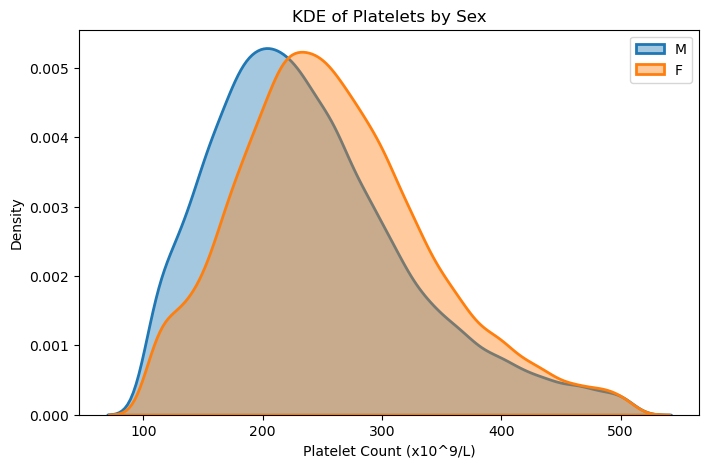

In [13]:
plot_platelets_by_sex(df_platelets)

##### Figura 5

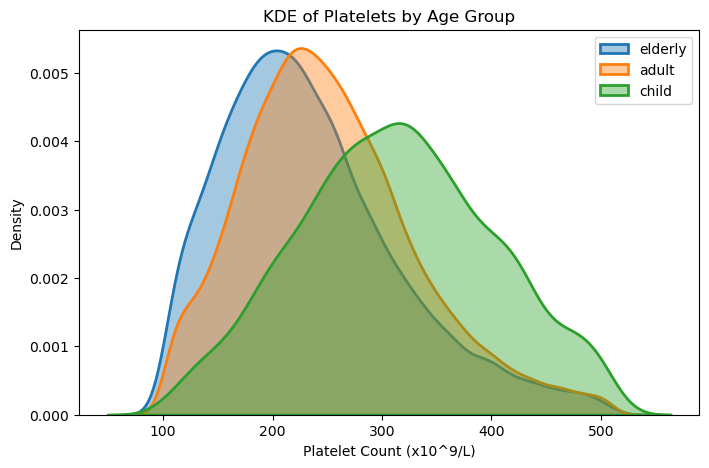

In [14]:
plot_platelets_by_age_group(df_platelets)

##### Figura 6

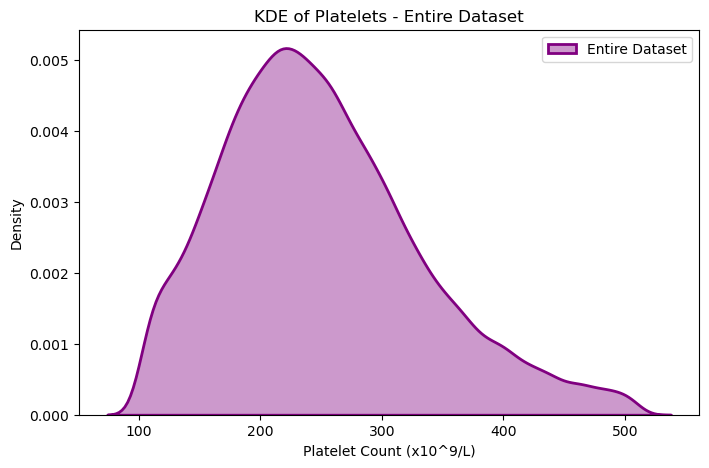

In [15]:
plot_platelets_entire_dataset(df_platelets)

##### Tabela 1

In [16]:
def filter_platelets(df, max_value=1000):
    """Filter platelet values <= max_value"""
    return df[df["value"] <= max_value].copy()


def calculate_ci(data, percentile, confidence=0.95):
    """Calculate confidence interval for a given percentile"""
    n = len(data)
    if n < 2:
        return np.nan, np.nan

    p_value = np.percentile(data, percentile)
    sorted_data = np.sort(data)
    p = percentile / 100

    # Standard error approximation
    se = np.sqrt(p * (1 - p) / n) * (sorted_data[-1] - sorted_data[0])
    z_score = stats.norm.ppf((1 + confidence) / 2)
    margin = z_score * se

    return max(0, p_value - margin), p_value + margin


def create_summary_row(data, group_name):
    """Create a summary row for a group"""
    n = len(data)
    if n == 0:
        return {
            "Group": group_name,
            "n": 0,
            "mean (SD)": "NA",
            "2.5th-97.5th": "NA",
            "2.5th (95%CI)": "NA",
            "97.5th (95%CI)": "NA",
        }

    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)

    p2_5 = np.percentile(data, 2.5)
    p97_5 = np.percentile(data, 97.5)

    ci_2_5_lower, ci_2_5_upper = calculate_ci(data, 2.5)
    ci_97_5_lower, ci_97_5_upper = calculate_ci(data, 97.5)

    return {
        "Group": group_name,
        "n": n,
        "mean (SD)": f"{mean_val:.0f} ({std_val:.1f})",
        "2.5th-97.5th": f"{p2_5:.0f}–{p97_5:.0f}",
        "2.5th (95%CI)": f"{ci_2_5_lower:.0f}–{ci_2_5_upper:.0f}",
        "97.5th (95%CI)": f"{ci_97_5_lower:.0f}–{ci_97_5_upper:.0f}",
    }


def generate_summary(df):
    """Generate summary rows for all age/sex groups"""
    df_platelets = filter_platelets(df)

    summary_rows = []

    # <15 years (All children)
    children_data = df_platelets[df_platelets["age_group"] == "child"]["value"]
    summary_rows.append(create_summary_row(children_data, "All"))

    # 15-64 years
    adult_men = df_platelets[
        (df_platelets["age_group"] == "adult") & (df_platelets["sex"] == "M")
    ]["value"]
    adult_women = df_platelets[
        (df_platelets["age_group"] == "adult") & (df_platelets["sex"] == "F")
    ]["value"]

    summary_rows.append(create_summary_row(adult_men, "Men"))
    summary_rows.append(create_summary_row(adult_women, "Women"))

    # >64 years
    elderly_men = df_platelets[
        (df_platelets["age_group"] == "elderly") & (df_platelets["sex"] == "M")
    ]["value"]
    elderly_women = df_platelets[
        (df_platelets["age_group"] == "elderly") & (df_platelets["sex"] == "F")
    ]["value"]

    summary_rows.append(create_summary_row(elderly_men, "Men"))
    summary_rows.append(create_summary_row(elderly_women, "Women"))

    return pd.DataFrame(summary_rows)


def print_summary_table(summary_rows):
    """Pretty-print the summary table"""
    print("Platelet Summary Statistics")
    print("=" * 80)
    print()
    print(
        f"{'Age':<12} {'n':<8} {'mean':<12} {'2.5th–':<12} "
        f"{'2.5th':<12} {'97.5th':<12}"
    )
    print(
        f"{'':12} {'':8} {'(SD)':<12} {'97.5th':<12} "
        f"{'(95%CI)':<12} {'(95%CI)':<12}"
    )
    print("-" * 80)

    # <15 years
    print("<15 years\n")
    row = summary_rows.iloc[0]
    print(
        f"{'All':<12} {row['n']:<8} {row['mean (SD)']:<12} "
        f"{row['2.5th-97.5th']:<12} {row['2.5th (95%CI)']:<12} "
        f"{row['97.5th (95%CI)']:<12}"
    )

    # 15-64 years
    print("\n15-64 years\n")
    for i in [1, 2]:
        row = summary_rows.iloc[i]
        print(
            f"{row['Group']:<12} {row['n']:<8} {row['mean (SD)']:<12} "
            f"{row['2.5th-97.5th']:<12} {row['2.5th (95%CI)']:<12} "
            f"{row['97.5th (95%CI)']:<12}"
        )

    # >64 years
    print("\n>64 years\n")
    for i in [3, 4]:
        row = summary_rows.iloc[i]
        print(
            f"{row['Group']:<12} {row['n']:<8} {row['mean (SD)']:<12} "
            f"{row['2.5th-97.5th']:<12} {row['2.5th (95%CI)']:<12} "
            f"{row['97.5th (95%CI)']:<12}"
        )

    print("\nSD, standard deviation; CI, confidence interval.")


# === Example usage ===
summary_df = generate_summary(df)
print_summary_table(summary_df)

Platelet Summary Statistics

Age          n        mean         2.5th–       2.5th        97.5th      
                      (SD)         97.5th       (95%CI)      (95%CI)     
--------------------------------------------------------------------------------
<15 years

All          2949     313 (89.0)   141–488      139–143      486–490     

15-64 years

Men          16988    241 (79.9)   115–439      114–116      438–440     
Women        19711    262 (77.7)   124–441      123–125      440–442     

>64 years

Men          8621     225 (80.4)   112–431      111–113      430–432     
Women        7500     245 (81.9)   115–441      114–116      440–442     

SD, standard deviation; CI, confidence interval.


### Modelo de síntese

#### Modelo bayesiano

In [17]:
# Define groups
def assign_group(row):
    if row["age_group"] == "child" and row["sex"] == "M":
        return "child_male"
    elif row["age_group"] == "child" and row["sex"] == "F":
        return "child_female"
    elif row["age_group"] == "adult" and row["sex"] == "M":
        return "adult_male"
    elif row["age_group"] == "adult" and row["sex"] == "F":
        return "adult_female"
    elif row["age_group"] == "elderly" and row["sex"] == "M":
        return "elderly_male"
    elif row["age_group"] == "elderly" and row["sex"] == "F":
        return "elderly_female"

df["group"] = df.apply(assign_group, axis=1)

def fit_group_models(df):
    """
    Fit separate log-normal models for each group.
    
    Returns:
        tuple: (group_traces, group_models) dictionaries
    """
    group_traces = {}
    group_models = {}
    
    for group_name, group_df in df.groupby("group"):
        print(f"Fitting model for {group_name} (n={len(group_df)})")
        
        with pm.Model() as model:
            # Priors for log-normal parameters
            mu = pm.Normal("mu", mu=np.log(250), sigma=1.0)
            sigma = pm.HalfNormal("sigma", sigma=1.0)
            
            # Likelihood (using "value" column)
            platelets = pm.Lognormal(
                "platelets",
                mu=mu,
                sigma=sigma,
                observed=group_df["value"].values,
            )
            
            # Faster sampling: fewer draws, fewer chains
            trace = pm.sample(
                2000, tune=2000, chains=4, cores=2, target_accept=0.9, random_seed=42
            )
        
        group_traces[group_name] = trace
        group_models[group_name] = model
    
    return group_traces, group_models

# group_traces, group_models = fit_group_models(df)

In [18]:
def post_process_synthetic_data(group_models, group_traces, df):
    """
    Generate synthetic data for each group based on posterior predictive sampling.
    Returns a DataFrame with synthetic values and their corresponding groups.
    """

    synthetic_data = []

    for group_name, model in group_models.items():
        trace = group_traces[group_name]
        n_target = (df["group"] == group_name).sum()  # original group size

        with model:
            posterior_predictive = pm.sample_posterior_predictive(
                trace, var_names=["platelets"], random_seed=42
            )

        # Extract posterior predictive samples
        values = (
            posterior_predictive.posterior_predictive["platelets"]
            .stack(sample=("chain", "draw"))
            .values
        )

        flat_values = values.reshape(-1)

        # Sample exactly as many as original group size
        chosen = np.random.choice(flat_values, size=n_target, replace=False)

        synthetic_df = pd.DataFrame({
            "value": chosen,
            "group": group_name
        })

        synthetic_data.append(synthetic_df)

    # Split group back into age_group and sex
    # Combine all groups
    synthetic_df = pd.concat(synthetic_data, ignore_index=True)

    # Map group → (age_group, sex)
    group_map = {
        "child_male" : ("child", "M"),
        "child_female": ("child", "F"),
        "adult_male": ("adult", "M"),
        "adult_female": ("adult", "F"),
        "elderly_male": ("elderly", "M"),
        "elderly_female": ("elderly", "F"),
    }

    synthetic_df[["age_group", "sex"]] = synthetic_df["group"].map(group_map).apply(pd.Series)
    return synthetic_df

# synthetic_df = post_process_synthetic_data(group_models, group_traces, df)

In [19]:
def build_age_references(df: pd.DataFrame) -> dict:
    """
    Build a dictionary mapping (age_group, sex) -> np.ndarray of ages.
    """
    return (
        df.groupby(["age_group", "sex"])["age"]
        .apply(lambda x: x.values)
        .to_dict()
    )


def sample_group_fast(group: pd.DataFrame, age_references: dict) -> pd.Series:
    """
    Sample ages for a single group using fast integer indexing.
    """
    ref = age_references[(group.name[0], group.name[1])]
    idx = np.random.randint(0, len(ref), size=len(group))
    return pd.Series(ref[idx], index=group.index)


def generate_synthetic_ages(
    synthetic_df: pd.DataFrame, age_references: dict
) -> pd.DataFrame:
    """
    Generate synthetic ages for each (age_group, sex) in synthetic_df
    using the provided age_references.
    """
    synthetic_df = synthetic_df.copy()
    synthetic_df["age"] = synthetic_df.groupby(
        ["age_group", "sex"], group_keys=False
    ).apply(lambda g: sample_group_fast(g, age_references))
    return synthetic_df

In [20]:
# age_references = build_age_references(df)
# synthetic_df = generate_synthetic_ages(synthetic_df, age_references)

In [21]:
# compare synthetic_df with df using kolmogorov-smirnov test
from scipy.stats import ks_2samp
# Function to compare distributions using KS test
def compare_distributions(df1, df2, column):
    """Compare two DataFrames' distributions using KS test."""
    stat, p_value = ks_2samp(df1[column], df2[column])
    return stat, p_value  

# compare synthetic_df with df
# ks_stat, ks_p_value = compare_distributions(df_platelets, synthetic_df, "value")
# print(f"KS Statistic: {ks_stat}, p-value: {ks_p_value}")

In [22]:
# summary_df = generate_summary(df)
# print_summary_table(summary_df)

# summary_df = generate_summary(synthetic_df)
# print_summary_table(summary_df)

In [23]:
# df_synth_platelets = preprocess_platelets(synthetic_df)
# plot_platelets_by_sex(df_platelets, df_synth_platelets)
# plot_platelets_by_age_group(df_platelets, df_synth_platelets)
# plot_platelets_entire_dataset(df_platelets, df_synth_platelets)

In [24]:
def save_to_csv(df: pd.DataFrame, filename: str):
    """
    Save DataFrame to CSV with specific formatting.
    """
    df = df.copy()
    df["timestamp"] = df["timestamp"].dt.strftime('%Y-%m-%d %H:%M:%S')
    df.to_csv(filename, index=False)

    # remove group and age_group columns
    df = df.drop(columns=["group", "age_group"], errors='ignore')

    # add random timestamp to each row, starting from the last timestamp in the original data, if its smaller than current time
    # the timestamps have to be smaller than the current time
    last_timestamp = df["timestamp"].max()
    current_time = pd.Timestamp.now()
    if last_timestamp < current_time:
        time_diff = current_time - last_timestamp
        random_timestamps = last_timestamp + pd.to_timedelta(
            np.random.rand(len(df)) * time_diff.total_seconds(), unit='s'
        )
        df["timestamp"] = random_timestamps
    else:
        df["timestamp"] = last_timestamp + pd.to_timedelta(
            np.random.rand(len(df)) * 60, unit='s'  # small random offset
        )

    # add random id column, larger than 0 and smaller than 99999999. Cannot be the same as any id in the original data or synthetic data
    existing_ids = set(df["id"].astype(str))
    synthetic_ids = set()
    while len(synthetic_ids) < len(df):
        new_id = str(np.random.randint(1, 99999999))
        if new_id not in existing_ids and new_id not in synthetic_ids:
            synthetic_ids.add(new_id)
            
    df["id"] = list(synthetic_ids)

    # Reorder columns to match original DataFrame
    df["analyte"] = "PLAQUETAS SANGUE"

    df = df[["timestamp", "age", "id", "sex", "analyte", "value"]]

    # Save the synthetic DataFrame to a CSV file. timestamp needs to be in the format YYYY-MM-DD HH:MM:SS without milliseconds
    df["timestamp"] = df["timestamp"].dt.strftime('%Y-%m-%d %H:%M:%S')
    df.to_csv("synthetic_platelets.csv", index=False)

# save_to_csv(synthetic_df, "synthetic_platelets.csv")

#### Other models

In [25]:
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

ctgan_df = df.copy()
ctgan_df["age_group"] = ctgan_df["age_group"].astype("object")
ctgan_df["sex"] = ctgan_df["sex"].astype("object")

def undersample_by_category(df, category_col, random_state=42):
  """
  Undersample all categories to match the size of the smallest category.
  
  Parameters:
  -----------
  df : pd.DataFrame
    Input dataframe
  category_col : str
    Column name to use for undersampling
  random_state : int
    Random seed for reproducibility
    
  Returns:
  --------
  pd.DataFrame
    Undersampled dataframe
  """
  # Find the minimum count across all categories
  min_count = df[category_col].value_counts().min()
  
  # Sample each category to the minimum count
  undersampled_dfs = []
  for category in df[category_col].unique():
    category_df = df[df[category_col] == category]
    sampled_df = category_df.sample(n=min_count, random_state=random_state)
    undersampled_dfs.append(sampled_df)
  
  # Concatenate all undersampled dataframes
  result_df = pd.concat(undersampled_dfs, ignore_index=True)
  
  print(f"Original dataset size: {len(df)}")
  print(f"Undersampled to {min_count} samples per category")
  print(f"Final dataset size: {len(result_df)}")
  
  return result_df

# Apply undersampling to ctgan_df based on a combination of age_group and sex
ctgan_df['category_combo'] = ctgan_df['age_group'] + '_' + ctgan_df['sex']
# ctgan_df = undersample_by_category(ctgan_df, 'category_combo')
# ctgan_df = ctgan_df.drop(columns=['category_combo'])

ctgan_df = ctgan_df[["category_combo", "value"]]

In [ ]:
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

ctgan_df = df.copy()
ctgan_df["age_group"] = ctgan_df["age_group"].astype("object")
ctgan_df["sex"] = ctgan_df["sex"].astype("object")

# Set up metadata
metadata = SingleTableMetadata()
metadata.add_column(column_name="category_combo", sdtype="categorical")
metadata.add_column(column_name="value", sdtype="numerical")

def undersample_by_category(df, category_col, random_state=42):
  """
  Undersample all categories to match the size of the smallest category.
  
  Parameters:
  -----------
  df : pd.DataFrame
    Input dataframe
  category_col : str
    Column name to use for undersampling
  random_state : int
    Random seed for reproducibility
    
  Returns:
  --------
  pd.DataFrame
    Undersampled dataframe
  """
  # Find the minimum count across all categories
  min_count = df[category_col].value_counts().min()
  
  # Sample each category to the minimum count
  undersampled_dfs = []
  for category in df[category_col].unique():
    category_df = df[df[category_col] == category]
    sampled_df = category_df.sample(n=min_count, random_state=random_state)
    undersampled_dfs.append(sampled_df)
  
  # Concatenate all undersampled dataframes
  result_df = pd.concat(undersampled_dfs, ignore_index=True)
  
  print(f"Original dataset size: {len(df)}")
  print(f"Undersampled to {min_count} samples per category")
  print(f"Final dataset size: {len(result_df)}")
  
  return result_df

def train_ctgan_model(df, metadata=metadata, num_samples=10000, epochs=400, verbose=True):
  """
  Train a CTGAN model on platelet data and generate synthetic samples.
  
  Parameters:
  -----------
  df : pd.DataFrame
    Original dataframe with platelet data
  num_samples : int
    Number of synthetic samples to generate
  epochs : int
    Number of training epochs
  verbose : bool
    Whether to show training progress
    
  Returns:
  --------
  tuple
    (model, synthetic_df) - trained model and synthetic data
  """
  # Prepare data for CTGAN
  ctgan_df = df.copy()
  ctgan_df["age_group"] = ctgan_df["age_group"].astype("object")
  ctgan_df["sex"] = ctgan_df["sex"].astype("object")
  
  # Create category combination
  ctgan_df['category_combo'] = ctgan_df['age_group'] + '_' + ctgan_df['sex']
  ctgan_df = ctgan_df[["category_combo", "value"]]
  
  # Initialize and configure model
  model = CTGANSynthesizer(
    metadata,
    embedding_dim=128,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    batch_size=500,
    discriminator_steps=1,
    log_frequency=True,
    epochs=epochs,
    pac=10,
    verbose=verbose,
    cuda=True
  )
  
  # Train model
  model.fit(ctgan_df)
  
  model.save("ctgan_platelet_model.pkl")
  
  # Generate synthetic data
  synthetic_df = model.sample(num_samples)
  
  # Add age_group and sex from category_combo
  synthetic_df["age_group"] = synthetic_df["category_combo"].apply(lambda x: x.split('_')[0])
  synthetic_df["sex"] = synthetic_df["category_combo"].apply(lambda x: x.split('_')[1])
  
  # Build age references from original data
  age_references = build_age_references(df)
  
  # Generate realistic ages for synthetic data
  synthetic_df = generate_synthetic_ages(synthetic_df, age_references)
  
  return model, synthetic_df

model, synthetic_df = train_ctgan_model(df, num_samples=1000, epochs=400, verbose=True)

/home/kris/miniforge3/envs/torch/lib/python3.11/site-packages/sdv/single_table/base.py:167: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

/home/kris/miniforge3/envs/torch/lib/python3.11/site-packages/sdv/single_table/base.py:133: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Gen. (-0.34) | Discrim. (-0.24): 100%|██████████| 400/400 [09:51<00:00,  1.48s/it]
/tmp/ipykernel_55075/1957534216.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_55075/1957534216.py:31: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the ope

In [26]:
age_references = build_age_references(df)
synthetic_df = generate_synthetic_ages(synthetic_df, age_references)

/tmp/ipykernel_43155/1957534216.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_43155/1957534216.py:31: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [26]:
synthetic_df

,category_combo,value,age_group,sex,age
0,adult_M,395.0,adult,M,60
1,child_M,312.0,child,M,11
2,adult_M,379.0,adult,M,56
3,adult_F,274.0,adult,F,36
4,elderly_F,222.0,elderly,F,72
...,...,...,...,...,...
9995,elderly_F,345.0,elderly,F,71
9996,child_F,382.0,child,F,13
9997,elderly_F,356.0,elderly,F,75
9998,child_M,415.0,child,M,9


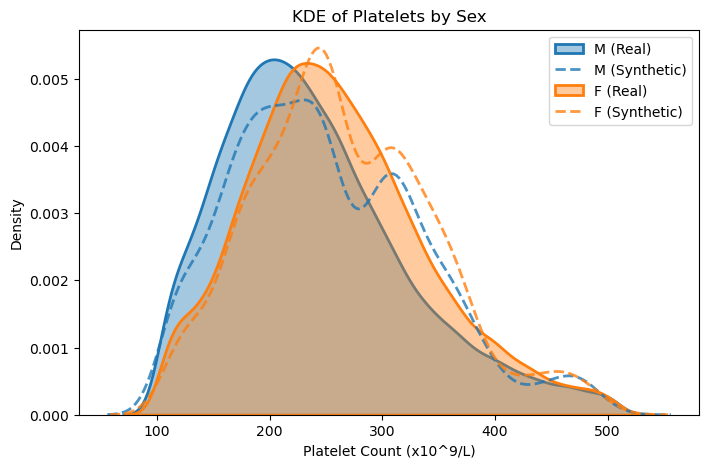

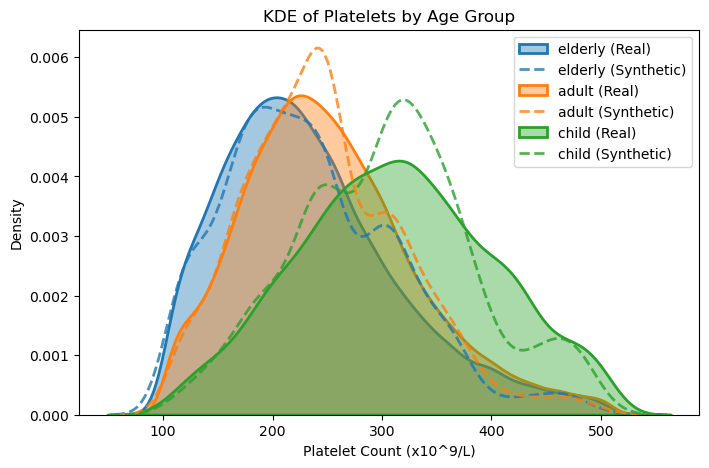

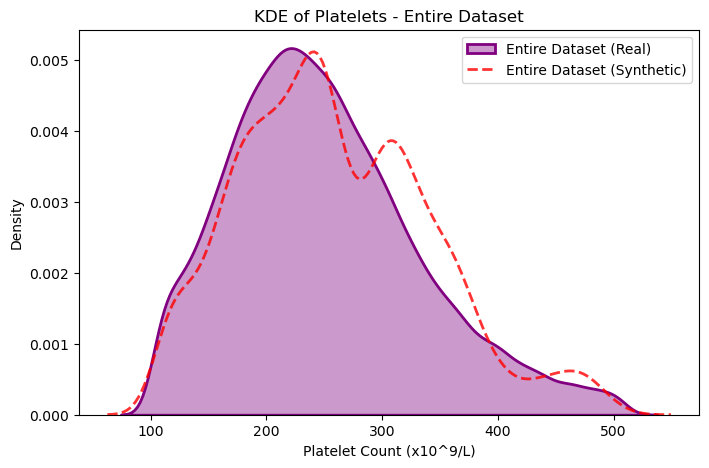

In [29]:
df_synth_platelets = preprocess_platelets(synthetic_df)
plot_platelets_by_sex(df_platelets, df_synth_platelets)
plot_platelets_by_age_group(df_platelets, df_synth_platelets)
plot_platelets_entire_dataset(df_platelets, df_synth_platelets)

In [30]:
summary_df = generate_summary(df)
print_summary_table(summary_df)

summary_df = generate_summary(synthetic_df)
print_summary_table(summary_df)

Platelet Summary Statistics

Age          n        mean         2.5th–       2.5th        97.5th      
                      (SD)         97.5th       (95%CI)      (95%CI)     
--------------------------------------------------------------------------------
<15 years

All          2949     313 (89.0)   141–488      139–143      486–490     

15-64 years

Men          16988    241 (79.9)   115–439      114–116      438–440     
Women        19711    262 (77.7)   124–441      123–125      440–442     

>64 years

Men          8621     225 (80.4)   112–431      111–113      430–432     
Women        7500     245 (81.9)   115–441      114–116      440–442     

SD, standard deviation; CI, confidence interval.
Platelet Summary Statistics

Age          n        mean         2.5th–       2.5th        97.5th      
                      (SD)         97.5th       (95%CI)      (95%CI)     
--------------------------------------------------------------------------------
<15 years

All          278

In [35]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    ctgan_df[["category_combo", "value"]],
    synthetic_df[["category_combo", "value"]],
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 2/2 [00:00<00:00, 36.09it/s]|
Column Shapes Score: 82.03%

(2/2) Evaluating Column Pair Trends: |██████████| 1/1 [00:00<00:00, 20.04it/s]|
Column Pair Trends Score: 70.94%

Overall Score (Average): 76.48%



In [ ]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,age_group,TVComplement,0.846063
1,sex,TVComplement,0.988529
2,value,KSComplement,0.929242


# Bibliografia

1. [Biino, G., Santimone, I., Minelli, C., Sorice, R., Frongia, B., Traglia, M., Ulivi, S., Di Castelnuovo, A., Gögele, M., Nutile, T., Francavilla, M., Sala, C., Pirastu, N., Cerletti, C., Iacoviello, L., Gasparini, P., Toniolo, D., Ciullo, M., Pramstaller, P., Pirastu, M., … Balduini, C. L. (2013). Age- and sex-related variations in platelet count in Italy: A proposal of reference ranges based on 40987 subjects' data. *PLOS ONE*, *8*(1), 1–7.](https://doi.org/10.1371/journal.pone.0054289)

2. [Simmonds, J., Dube, K., Gallagher, T., Fenton, N., & McLachlan, S. (2019). Realistic Synthetic Data Generation: The ATEN Framework.](https://www.researchgate.net/publication/325824760_Realistic_Synthetic_Data_Generation_The_ATEN_Framework)